In [3]:
from pathlib import Path
import sys

# If this notebook lives in /notebooks, set ROOT to repo root
ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
assert (ROOT / "src").exists(), f"'src' not found at {ROOT}. Start Jupyter from repo root or put this notebook in /notebooks."

# Make repo root importable
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))

print("ROOT:", ROOT)

ROOT: /Users/jkim/Projects/stock-sentiment-analyzer


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import torch
import transformers

from src.models.finbert import load_finbert_pipeline, score_finbert_df

# Try to import your cleaner; if missing, define a tiny fallback
try:
    from src.preprocess.text import basic_clean
except Exception:
    import re
    _url = re.compile(r"http\S+"); _ws = re.compile(r"\s+")
    def basic_clean(s: str) -> str:
        s = s.lower()
        s = _url.sub(" ", s)
        s = re.sub(r"\$[a-z]{1,5}", " ", s)      # $AAPL
        s = re.sub(r"@[A-Za-z0-9_]+", " ", s)    # @handles
        s = re.sub(r"#[A-Za-z0-9_]+", " ", s)    # #hashtags
        s = re.sub(r"[^a-z0-9\.\,\!\?\:\;\-\s]", " ", s)
        return _ws.sub(" ", s).strip()

print("torch:", torch.__version__, "| MPS available:", torch.backends.mps.is_available())
print("transformers:", transformers.__version__)

/Users/jkim/Projects/stock-sentiment-analyzer/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch: 2.8.0 | MPS available: True
transformers: 4.55.4


In [5]:
DATA_RAW = ROOT / "data" / "raw"
DATA_PROCESSED = ROOT / "data" / "processed"
DATA_PROCESSED.mkdir(parents=True, exist_ok=True)

csv_path = DATA_RAW / "synthetic_fintext.csv"   # adjust if different

if csv_path.exists():
    df = pd.read_csv(csv_path)
else:
    # Tiny fallback sample so you can run end-to-end immediately
    df = pd.DataFrame({
        "text": [
            "Apple stock rallies after record earnings!",
            "Tesla faces SEC investigation, outlook uncertain.",
            "Markets remain flat ahead of Federal Reserve decision."
        ],
        # optional ground-truth for quick eval
        "label_bucket": ["positive","negative","neutral"]
    })
    print("Note: using tiny inline sample because", csv_path, "was not found.")

# Keep only relevant columns if present
cols_keep = [c for c in ["timestamp","text","ticker","source","label_bucket"] if c in df.columns]
if cols_keep:
    df = df[cols_keep]

# Basic hygiene
df = df[df["text"].notna()].copy()
df["text_clean"] = df["text"].astype(str).map(basic_clean)
df.head(5)

,timestamp,text,ticker,source,label_bucket,text_clean
0,2025-08-16T00:29:21,IMO: TSLA massive beat 😤 #AI DYOR,TSLA,news,positive,imo: tsla massive beat dyor
1,2025-08-16T01:13:21,$AAPL @jimcramer Breaking: AAPL waiting for ea...,AAPL,news,neutral,breaking: aapl waiting for earnings dyor
2,2025-08-16T02:06:21,$SOFI @barronsonline FYI: SOFI sector rotation...,SOFI,news,neutral,fyi: sofi sector rotation
3,2025-08-16T02:17:21,$AAPL Update: AAPL profit warning ❌,AAPL,reddit,negative,update: aapl profit warning
4,2025-08-16T03:28:21,$TSLA Breaking: TSLA strong demand ✅ #stocks,TSLA,twitter,positive,breaking: tsla strong demand


In [6]:
# Use 'mps' for Apple Silicon acceleration; switch to "cpu" if you hit any backend quirks
pipe = load_finbert_pipeline(device_preference="mps", batch_size=16)
pipe

Device set to use mps:0
/Users/jkim/Projects/stock-sentiment-analyzer/venv/lib/python3.12/site-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [7]:
scored = score_finbert_df(df, text_col="text_clean", pipe=pipe, batch_size=16)
scored.head(10)

,timestamp,text,ticker,source,label_bucket,text_clean,POSITIVE,NEUTRAL,NEGATIVE,pred_label,pred_score
0,2025-08-16T00:29:21,IMO: TSLA massive beat 😤 #AI DYOR,TSLA,news,positive,imo: tsla massive beat dyor,1.883826e-04,9.993824e-01,4.292829e-04,NEUTRAL,0.999382
1,2025-08-16T01:13:21,$AAPL @jimcramer Breaking: AAPL waiting for ea...,AAPL,news,neutral,breaking: aapl waiting for earnings dyor,4.227004e-02,8.000789e-01,1.576510e-01,NEUTRAL,0.800079
2,2025-08-16T02:06:21,$SOFI @barronsonline FYI: SOFI sector rotation...,SOFI,news,neutral,fyi: sofi sector rotation,1.945835e-03,9.587398e-01,3.931442e-02,NEUTRAL,0.958740
3,2025-08-16T02:17:21,$AAPL Update: AAPL profit warning ❌,AAPL,reddit,negative,update: aapl profit warning,8.291307e-01,7.274685e-03,1.635945e-01,POSITIVE,0.829131
4,2025-08-16T03:28:21,$TSLA Breaking: TSLA strong demand ✅ #stocks,TSLA,twitter,positive,breaking: tsla strong demand,1.000000e+00,2.973716e-09,5.417216e-09,POSITIVE,1.000000
5,2025-08-16T05:39:21,Update: SOFI strong demand 😤 DYOR,SOFI,reddit,positive,update: sofi strong demand dyor,1.000000e+00,1.216122e-08,1.051122e-08,POSITIVE,1.000000
6,2025-08-16T06:04:21,$TSLA Breaking: TSLA solid earnings 😤 #AI,TSLA,twitter,positive,breaking: tsla solid earnings,1.000000e+00,4.211592e-09,1.027705e-08,POSITIVE,1.000000
7,2025-08-16T07:09:21,@elonmusk TSLA rumors circulating 📰,TSLA,twitter,neutral,tsla rumors circulating,1.545066e-05,9.968039e-01,3.180691e-03,NEUTRAL,0.996804
8,2025-08-16T07:34:21,$SMR @jimcramer Update: SMR margin pressure ❌ ...,SMR,twitter,negative,update: smr margin pressure dyor,1.819220e-04,7.631433e-05,9.997417e-01,NEGATIVE,0.999742
9,2025-08-16T08:28:21,$MP Heads up: MP CEO interview airs 📌 #markets...,MP,reddit,neutral,heads up: mp ceo interview airs dyor,6.617960e-07,9.999734e-01,2.587871e-05,NEUTRAL,0.999973


In [8]:
out_path = DATA_PROCESSED / "finbert_scored.csv"
scored.to_csv(out_path, index=False)
out_path

PosixPath('/Users/jkim/Projects/stock-sentiment-analyzer/data/processed/finbert_scored.csv')

In [9]:
if "label_bucket" in scored.columns:
    y_true = scored["label_bucket"].str.lower()
    y_pred = scored["pred_label"].str.lower()
    print(classification_report(y_true, y_pred, digits=3))
    print(confusion_matrix(y_true, y_pred))
else:
    print("No ground-truth labels found (label_bucket). Skipping evaluation.")

              precision    recall  f1-score   support

    negative      0.833     0.812     0.823        80
     neutral      0.661     0.879     0.755        91
    positive      0.931     0.729     0.817       129

    accuracy                          0.797       300
   macro avg      0.808     0.807     0.798       300
weighted avg      0.823     0.797     0.800       300

[[65 14  1]
 [ 5 80  6]
 [ 8 27 94]]


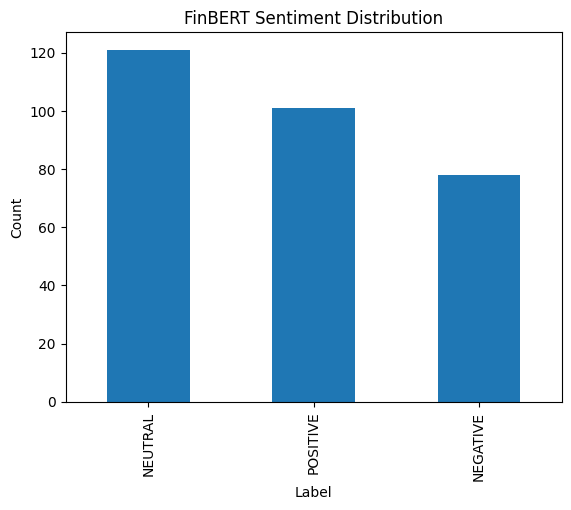

pred_label,NEGATIVE,NEUTRAL,POSITIVE
ticker,,,
AAPL,0.340909,0.295455,0.363636
MP,0.233333,0.400000,0.366667
NVDA,0.291667,0.270833,0.437500
SMR,0.265306,0.469388,0.265306
SOFI,0.186047,0.441860,0.372093
TSLA,0.250000,0.517857,0.232143


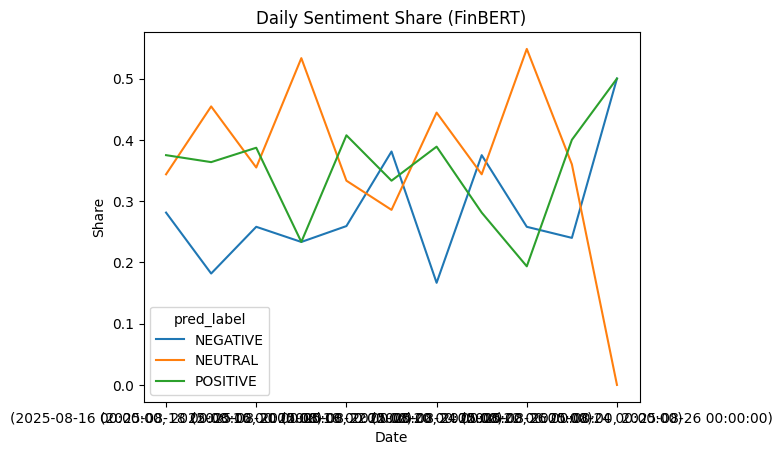

In [10]:
ax = scored["pred_label"].value_counts().plot(kind="bar")
ax.set_title("FinBERT Sentiment Distribution")
ax.set_xlabel("Label"); ax.set_ylabel("Count")
plt.show()

# Optional: by ticker/source if present
if "ticker" in scored.columns:
    display(scored.groupby("ticker")["pred_label"].value_counts(normalize=True).unstack(fill_value=0.0))

if "timestamp" in scored.columns:
    # If timestamps exist and are parseable, visualize sentiment share over time
    tmp = scored.copy()
    tmp["timestamp"] = pd.to_datetime(tmp["timestamp"], errors="coerce")
    tmp = tmp.dropna(subset=["timestamp"])
    if not tmp.empty:
        daily = (tmp
                 .assign(count=1)
                 .groupby([pd.Grouper(key="timestamp", freq="D"), "pred_label"])["count"]
                 .sum()
                 .groupby(level=0).apply(lambda s: s / s.sum())
                 .unstack(fill_value=0.0))
        daily.plot()
        plt.title("Daily Sentiment Share (FinBERT)")
        plt.xlabel("Date"); plt.ylabel("Share")
        plt.show()

In [11]:
# Keep only the essentials for side-by-side comparisons later
compare_cols = [c for c in ["timestamp","ticker","source","text","label_bucket","pred_label","pred_score","POSITIVE","NEUTRAL","NEGATIVE"] if c in scored.columns]
scored[compare_cols].to_csv(DATA_PROCESSED / "finbert_compact.csv", index=False)
print("Wrote:", DATA_PROCESSED / "finbert_compact.csv")

Wrote: /Users/jkim/Projects/stock-sentiment-analyzer/data/processed/finbert_compact.csv
